# Introduction

In the previous Notebook, we saw that Seam Carving can help reudcing dimensions of images without losing important parts. In this notebook, we will test this solution versus the normal rescaling on the Stanford Dataset. In this dataset, we have 120 breeds of dogs to classify from 100 images of each. The test set is composed of a random number of each classes (ween more in detail in the part 1). The dataset will be pre-processed with both solution and compared in term of Loss and Accuracy. 

In [1]:
import os
import scipy.io
from imageio import imread, imwrite
import pandas as pd

import numba
import numpy as np
from scipy.ndimage.filters import convolve
from skimage import transform,io

import matplotlib.pyplot as plt

# Dataset exploration

First of all, the dataset is composed by images in folder and information for train/test set in .mat files. We will have to create a dataframe with those information and after extract some features required to explore the dataset. Basically, the image size...

In [30]:
# obj = {
#     "image" : [],
#     "box" : [],
#     "label" : [],
#     "class_name" : [],
#     "dataset" : []
# }

# mat = scipy.io.loadmat("F:/data/DogBreed/Labels/train_list.mat")
# for img, label, box in zip(mat["file_list"], mat["labels"], mat["annotation_list"]):
#     obj["image"].append(img[0][0])
#     obj["label"].append(label[0])
#     obj["box"].append(box[0][0])
#     obj["class_name"].append(img[0][0].split("/")[0].split("-")[1])
#     obj["dataset"].append(0)

# mat = scipy.io.loadmat("F:/data/DogBreed/Labels/test_list.mat")
# for img, label, box in zip(mat["file_list"], mat["labels"], mat["annotation_list"]):
#     obj["image"].append(img[0][0])
#     obj["label"].append(label[0])
#     obj["box"].append(box[0][0])
#     obj["class_name"].append(img[0][0].split("/")[0].split("-")[1])
#     obj["dataset"].append(1)
    
# df = pd.DataFrame(obj)
# df.to_csv("F:/data/DogBreed/Labels/labels.csv", index=False)

In [35]:
# def get_size(x):
#     root = "F:/data/DogBreed/Images/"
#     img = imread(os.path.join(root, x))
#     w, h, d = img.shape
#     return "%d_%d"%(w, h)

# df["size"] = df["image"].apply(get_size)

In [38]:
# df["width"] = df["size"].apply(lambda x:int(x.split("_")[0]))
# df["height"] = df["size"].apply(lambda x:int(x.split("_")[1]))

In [90]:
# df.drop("size", axis=1, inplace=True)

In [ ]:
# df["ratio"] = df[["width", "height"]].apply(lambda x: x.max()/x.min(), axis=1)

In [92]:
# df.to_csv("F:/data/DogBreed/Labels/labels.csv", index=False)

In [4]:
df = pd.read_csv("F:/data/DogBreed/Labels/labels.csv")
df.head()

,box,class_name,dataset,image,label,width,height,ratio
0,n02085620-Chihuahua/n02085620_5927,Chihuahua,0,n02085620-Chihuahua/n02085620_5927.jpg,1,300,360,1.200000
1,n02085620-Chihuahua/n02085620_4441,Chihuahua,0,n02085620-Chihuahua/n02085620_4441.jpg,1,500,375,1.333333
2,n02085620-Chihuahua/n02085620_1502,Chihuahua,0,n02085620-Chihuahua/n02085620_1502.jpg,1,333,500,1.501502
3,n02085620-Chihuahua/n02085620_1916,Chihuahua,0,n02085620-Chihuahua/n02085620_1916.jpg,1,495,500,1.010101
4,n02085620-Chihuahua/n02085620_13151,Chihuahua,0,n02085620-Chihuahua/n02085620_13151.jpg,1,336,500,1.488095


We have now our final dataset. Let's explore it :

In [94]:
df.dataset.value_counts()

0    12000
1     8580
Name: dataset, dtype: int64

The dataset has 20580 pictures composed with 12000 of train images and 8580 for the evaluation. Let see by class :

In [95]:
classes = df[["class_name", "dataset", "image"]].groupby(["class_name", "dataset"]).count().reset_index().pivot(index="class_name", columns="dataset")
classes.columns = ["train", "test"]

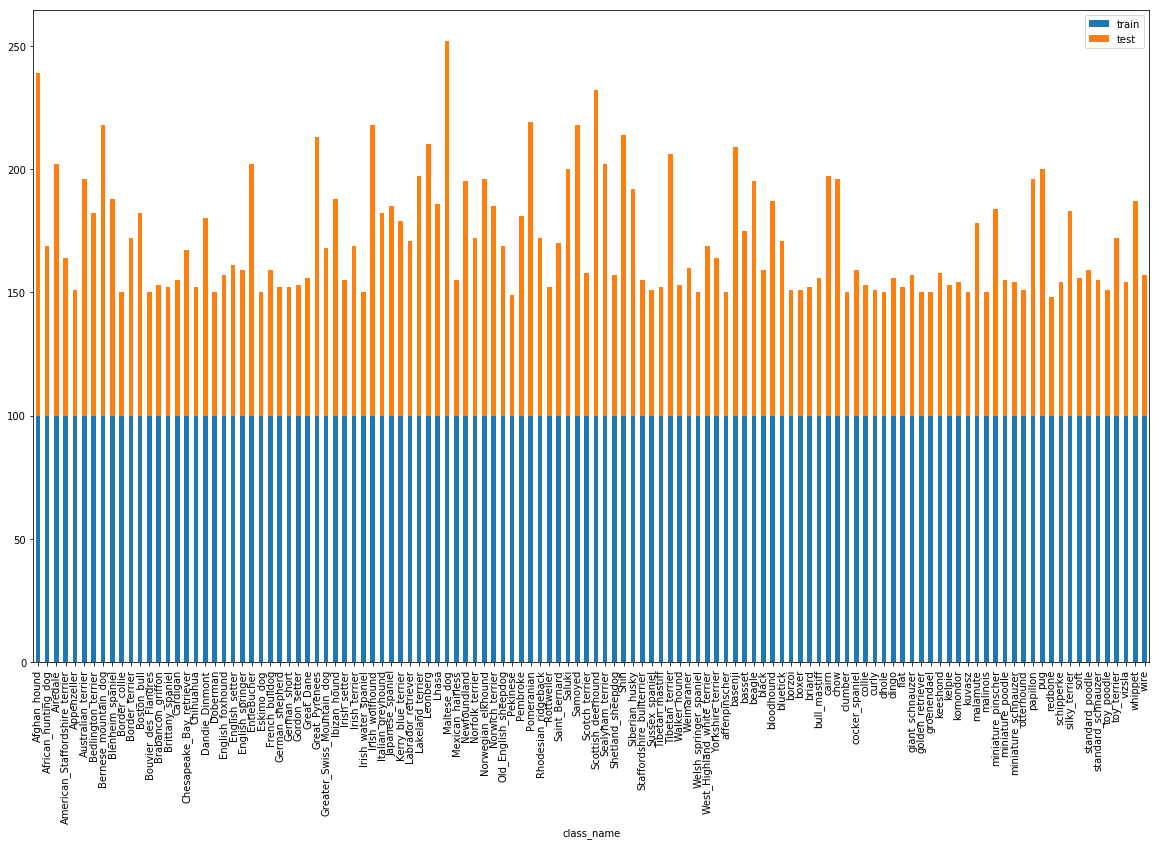

In [96]:
classes.plot.bar(stacked=True, figsize=(20,12))
plt.show()

As we knew from the dataset description, we have for each class, 100 images. When we have more, it's in the test set. Let's now look at image size and also the ratio

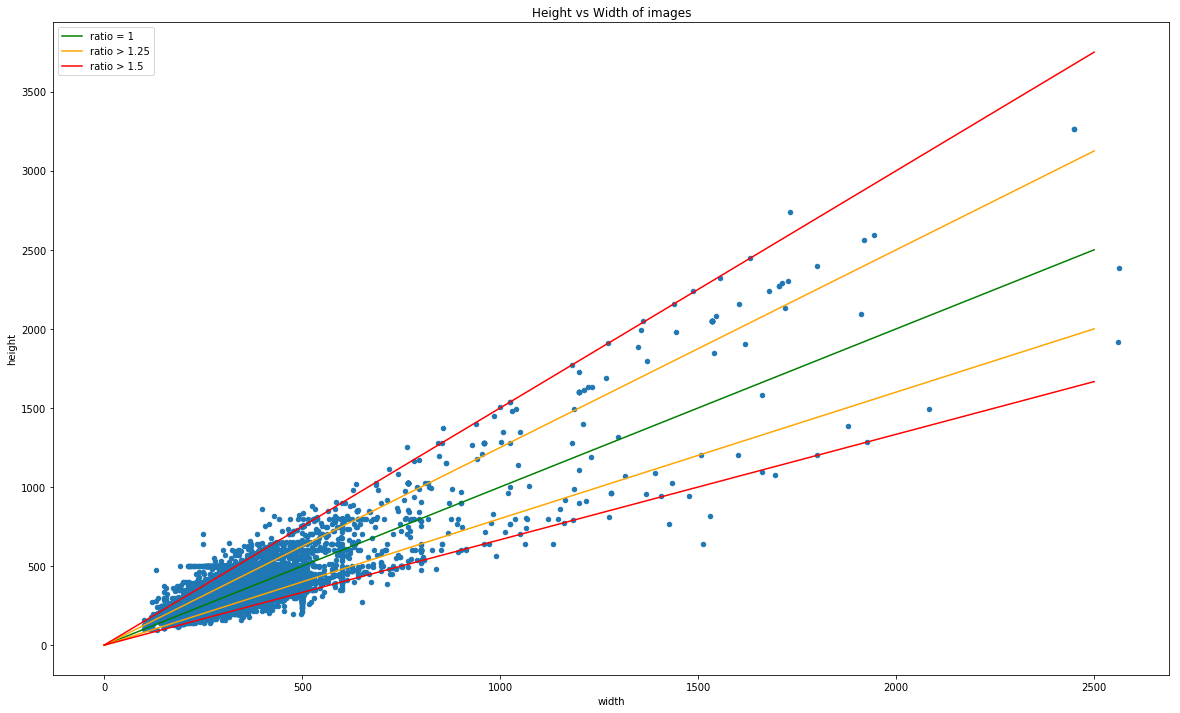

In [124]:
df.plot(kind="scatter", x="width", y="height", figsize=(20,12))
plt.plot([0, 2500], [0, 2500], c="green", label="ratio = 1")
plt.plot([0, 2500], [0, 2500*1.25], c="orange", label="ratio > 1.25")
plt.plot([0, 2500], [0, 2500/1.25], c="orange")
plt.plot([0, 2500], [0, 2500*1.5], c="r" , label="ratio > 1.5")
plt.plot([0, 2500], [0, 2500/1.5], c="r")
plt.legend()
plt.title("Height vs Width of images")
plt.show()

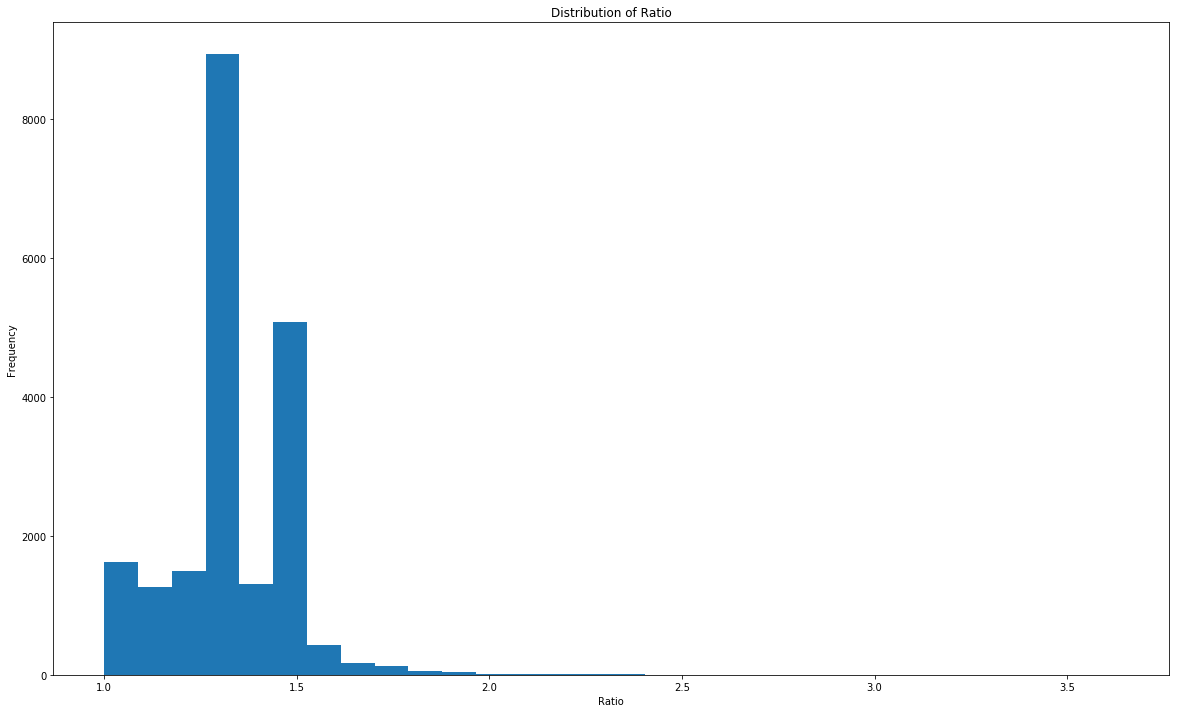

In [126]:
df["ratio"].plot.hist(bins=30, figsize=(20,12))
plt.xlabel("Ratio")
plt.title("Distribution of Ratio")
plt.show()

Let's look how many images we would have to resize based on the trigger to use simple "rescale"

In [15]:
(df.ratio >= 1.2).sum()

17362

In [99]:
(df.ratio >= 1.50).sum()

4622

In [100]:
(df.ratio >= 1.51).sum()

1111

In [101]:
(df.ratio > 2).sum()

44

In [89]:
df.ratio.max()

3.633587786259542

Due to the time to precess images, only the one with more than 1.51 will be passed thru seam carving to rescale them

# Pre-processing

Now, let's prepare both dataset. To save time, I wanted to use dask to have the power of multiprocessing but with @jit functions, it's not working. The benefit of @jit being > to multiprocessing, I ran the computation on a single core

In [3]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

@numba.jit
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

@numba.jit
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])
    
    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img


def crop_c(img, scale_c):
    r, c, _ = img.shape
    if isinstance(scale_c, float):
        new_c = int(scale_c * c)
    else:
        new_c = c-scale_c  # give a range(scale_c)

    for i in range(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

In [6]:
def edit_img(img_name, w, h, ratio):
    if img_name == "foo": return 1  # only to pass the test from dask
    
    root = "F:/data/DogBreed/Images"
    out_root = "F:/data/DogBreed/pre_processed/"
    name = img_name.split("/")[1]
    
    if os.path.isfile(os.path.join(out_root, name)):
        return 1

    img = imread(os.path.join(root, img_name))
    
    if ratio <= 1.51:
        img = transform.resize(img, (299, 299))
        imwrite(os.path.join(out_root, name), img)
    else:
        scale_f = min(w, h)/299
        img = transform.resize(img, (int(w/scale_f), int(h/scale_f)))
        w, h, _ = img.shape
        if w > h:
            img = crop_r(img, w-299)
        else:
            img = crop_c(img, h-299)
        imwrite(os.path.join(out_root, name), img)
    return 1

In [ ]:
df.apply(lambda x : edit_img(x.image, x.width, x.height, x.ratio), axis=1)

In [9]:
from shutil import copyfile

def edit_img_2(img_name, w, h, ratio):
    if img_name == "foo": return 1  # only to pass the test from dask
    
    root = "F:/data/DogBreed/Images"
    in_root = "F:/data/DogBreed/pre_processed/"
    out_root = "F:/data/DogBreed/simple_scale/"
    name = img_name.split("/")[1]
    if ratio <= 1.51:
        in_path = os.path.join(in_root, name)
        out_path = os.path.join(out_root, name)
        copyfile(in_path, out_path)
    else:
        img = imread(os.path.join(root, img_name))
        img = transform.resize(img, (299, 299))
        imwrite(os.path.join(out_root, name), img)
    return 1

In [ ]:
# df.apply(lambda x : edit_img_2(x.image, x.width, x.height, x.ratio), axis=1)

In [10]:
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

In [ ]:
nCores = 1
nCores = cpu_count()

meta = pd.DataFrame({'name': [1]}, columns=['name'])  # just because dask requires a return, I always return 1

dd.from_pandas(df, npartitions=nCores).\
   map_partitions(
      lambda df_ : df_.apply(
         lambda x : edit_img_2(x.image, x.width, x.height, x.ratio), axis=1), meta=meta).\
   compute(get=get)

In [49]:
# img = Image.open("F:/data/DogBreed/pre_processed/n02105855_2933.jpg")
# img = Image.fromarray(np.array(img)[:,:,:3], 'RGB')
# img.save("F:/data/DogBreed/pre_processed/n02105855_2933.jpg")

In [27]:
df[df.ratio > 1.5]

,box,class_name,dataset,image,label,width,height,ratio
2,n02085620-Chihuahua/n02085620_1502,Chihuahua,0,n02085620-Chihuahua/n02085620_1502.jpg,1,333,500,1.501502
15,n02085620-Chihuahua/n02085620_5771,Chihuahua,0,n02085620-Chihuahua/n02085620_5771.jpg,1,500,281,1.779359
16,n02085620-Chihuahua/n02085620_275,Chihuahua,0,n02085620-Chihuahua/n02085620_275.jpg,1,333,500,1.501502
18,n02085620-Chihuahua/n02085620_10621,Chihuahua,0,n02085620-Chihuahua/n02085620_10621.jpg,1,298,500,1.677852
22,n02085620-Chihuahua/n02085620_12101,Chihuahua,0,n02085620-Chihuahua/n02085620_12101.jpg,1,253,380,1.501976
30,n02085620-Chihuahua/n02085620_473,Chihuahua,0,n02085620-Chihuahua/n02085620_473.jpg,1,333,500,1.501502
31,n02085620-Chihuahua/n02085620_1455,Chihuahua,0,n02085620-Chihuahua/n02085620_1455.jpg,1,500,333,1.501502
38,n02085620-Chihuahua/n02085620_9357,Chihuahua,0,n02085620-Chihuahua/n02085620_9357.jpg,1,319,500,1.567398
44,n02085620-Chihuahua/n02085620_326,Chihuahua,0,n02085620-Chihuahua/n02085620_326.jpg,1,500,333,1.501502
72,n02085620-Chihuahua/n02085620_368,Chihuahua,0,n02085620-Chihuahua/n02085620_368.jpg,1,333,500,1.501502


Here it is, now there is 2 dataset of 299x299 images. One is fully rescaled, the other one passed thru seam carving if the ratio was above 1.51. Let's now extracxt both features to 2 different matrices 

# Feature Extraction

During the master on Data Science, I already made a comparison of feature extractor on that dataset and decided to go for InceptionV3, here I'll keep the same model

In [6]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import decode_predictions

from PIL import Image
import cv2

In [3]:
df = pd.read_csv("F:/data/DogBreed/Labels/labels.csv")
df.head()

,box,class_name,dataset,image,label,width,height,ratio
0,n02085620-Chihuahua/n02085620_5927,Chihuahua,0,n02085620-Chihuahua/n02085620_5927.jpg,1,300,360,1.200000
1,n02085620-Chihuahua/n02085620_4441,Chihuahua,0,n02085620-Chihuahua/n02085620_4441.jpg,1,500,375,1.333333
2,n02085620-Chihuahua/n02085620_1502,Chihuahua,0,n02085620-Chihuahua/n02085620_1502.jpg,1,333,500,1.501502
3,n02085620-Chihuahua/n02085620_1916,Chihuahua,0,n02085620-Chihuahua/n02085620_1916.jpg,1,495,500,1.010101
4,n02085620-Chihuahua/n02085620_13151,Chihuahua,0,n02085620-Chihuahua/n02085620_13151.jpg,1,336,500,1.488095


In [4]:
names = df["image"].apply(lambda x:x.split("/")[1])

I cannot load all the images in memory so I'll use a generator to predict by batch all the features and save afterward the 2 matrices

In [53]:
def image_generator(names, root):
    batch = 30
    n_iter = len(names)//batch
    X = np.zeros(shape=(batch, 299, 299, 3), dtype=np.float32)
    i=0
    while i < len(names):
        img = Image.open(os.path.join(root, names[i]))
        X[i%batch] = np.array(img)
        i+=1
        if i%batch==0:
            yield X/255.0

In [16]:
IMG_SHAPE = (299, 299, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [54]:
features = np.zeros(shape=(len(names), 2048), dtype=np.float32)
for k, x_ in enumerate(image_generator(names, "F:/data/DogBreed/simple_scale/")):
    y_hat = base_model.predict(x_)
    y_hat = np.mean(y_hat, axis=(1,2))
    features[30*k:30*(k+1), : ] = y_hat
np.save("F:/data/DogBreed/feature_scaled.npy", features)

In [56]:
features = np.zeros(shape=(len(names), 2048), dtype=np.float32)
for k, x_ in enumerate(image_generator(names, "F:/data/DogBreed/pre_processed/")):
    y_hat = base_model.predict(x_)
    y_hat = np.mean(y_hat, axis=(1,2))
    features[30*k:30*(k+1), : ] = y_hat
np.save("F:/data/DogBreed/feature_seamcarved.npy", features)

Here it is, we can now go to the classifier part ! (at this stage, I advise to restart the Kernel prior to continue)

# Prediction

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("F:/data/DogBreed/Labels/labels.csv")
df.head()

,box,class_name,dataset,image,label,width,height,ratio
0,n02085620-Chihuahua/n02085620_5927,Chihuahua,0,n02085620-Chihuahua/n02085620_5927.jpg,1,300,360,1.200000
1,n02085620-Chihuahua/n02085620_4441,Chihuahua,0,n02085620-Chihuahua/n02085620_4441.jpg,1,500,375,1.333333
2,n02085620-Chihuahua/n02085620_1502,Chihuahua,0,n02085620-Chihuahua/n02085620_1502.jpg,1,333,500,1.501502
3,n02085620-Chihuahua/n02085620_1916,Chihuahua,0,n02085620-Chihuahua/n02085620_1916.jpg,1,495,500,1.010101
4,n02085620-Chihuahua/n02085620_13151,Chihuahua,0,n02085620-Chihuahua/n02085620_13151.jpg,1,336,500,1.488095


Here we will have 3 parts, the train set, the test set and also only the images with more than 1.51 ratio to check only the impact of the method on this images (to avoid to diluate the benfit/loss within other images)

In [85]:
X_scaled = np.load("F:/data/DogBreed/feature_scaled.npy")
X_seam = np.load("F:/data/DogBreed/feature_seamcarved.npy")
y = np.array(df["class_name"]).reshape(-1, 1)
ds = np.array(df["dataset"])
to_eval = df[(df.ratio > 1.51) & (df.dataset == 1)].index
X_scaled_eval = X_scaled[to_eval]
X_seamed_eval = X_seam[to_eval]
y_scaled_eval = y[to_eval]

For the classifier, we need a OHE y-vector, let's use it also to process the images of high factor

In [86]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_ohe = lb.fit_transform(y)
y_eval = lb.transform(y_scaled_eval)

and finally, let's shuffle each datasets

In [88]:
from sklearn.utils import shuffle
X_scaled, X_seam, y_ohe, ds = shuffle(X_scaled, X_seam, y_ohe, ds, random_state=0)

Now we can build the model. I started from the base I had in the master. I'll keep the architecture as it gaves good results. The model will be trained with both dataset and stopped with an early stop to avoid overfitting.

In [89]:
import tensorflow as tf

def top2(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top3(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def top4(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top5(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

def swish(x):
    return x*tf.keras.backend.sigmoid(x)

tf.keras.utils.get_custom_objects().update({'custom_activation': swish})

In [98]:
tf.keras.backend.clear_session()

batch_size = 128
optimiser = "Adadelta"
metrics = ["accuracy", top3, top5]
epoch_max = 100
verbose = 1

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(200, input_dim=2048, activation="custom_activation"))
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(160, activation="custom_activation"))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(120, activation='softmax'))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [99]:
model.compile(loss = "categorical_crossentropy", optimizer=optimiser, metrics=metrics)
model.fit(X_scaled[ds==0], y_ohe[ds==0], 
          epochs=epoch_max, 
          batch_size=batch_size, 
          callbacks=[early_stop], 
          verbose=verbose,
          validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
9600/9600 [==============================] - 1s 53us/sample - loss: 2.1276 - acc: 0.5525 - top3: 0.7202 - top5: 0.7699 - val_loss: 0.5691 - val_acc: 0.8433 - val_top3: 0.9714 - val_top5: 0.9863
Epoch 2/100
9600/9600 [==============================] - 0s 35us/sample - loss: 0.6575 - acc: 0.8251 - top3: 0.9569 - top5: 0.9761 - val_loss: 0.4328 - val_acc: 0.8658 - val_top3: 0.9781 - val_top5: 0.9881
Epoch 3/100
9600/9600 [==============================] - 0s 35us/sample - loss: 0.5079 - acc: 0.8507 - top3: 0.9710 - top5: 0.9856 - val_loss: 0.4116 - val_acc: 0.8621 - val_top3: 0.9775 - val_top5: 0.9910
Epoch 4/100
9600/9600 [==============================] - 0s 34us/sample - loss: 0.4300 - acc: 0.8715 - top3: 0.9756 - top5: 0.9885 - val_loss: 0.4002 - val_acc: 0.8708 - val_top3: 0.9790 - val_top5: 0.9907
Epoch 5/100
9600/9600 [==============================] - 0s 35us/sample - loss: 0.3815 - acc: 0.8823 - top3: 0.9808 - top5: 0.99

The model is now trained with the images simply scaled. Let's evaluate it on the test set

In [115]:
score_scaled = model.evaluate(X_scaled[ds==1], y_ohe[ds==1], batch_size=128)
print(score_scaled)

8580/8580 [==============================] - 0s 19us/sample - loss: 0.3800 - acc: 0.8790 - top3: 0.9813 - top5: 0.9902
[0.38000432466849304, 0.879021, 0.981273, 0.9902344]


The performances are slightly below the train set which is logical but not that much. Let's now save the result only for high ratio images

In [116]:
score_scaled_eval = model.evaluate(X_scaled_eval, y_eval, batch_size=128)
print(score_scaled_eval)

450/450 [==============================] - 0s 22us/sample - loss: 0.5082 - acc: 0.8444 - top3: 0.9766 - top5: 0.9863
[0.5082035107745064, 0.84444445, 0.9765625, 0.9863281]


The loss is a lot higher, this is expected as we stretched features. Let's see how it goes with the dataset having the seam carving

In [102]:
model.compile(loss = "categorical_crossentropy", optimizer=optimiser, metrics=metrics)
model.fit(X_seam[ds==0], y_ohe[ds==0], 
          epochs=epoch_max, 
          batch_size=batch_size, 
          callbacks=[early_stop], 
          verbose=verbose,
          validation_split=0.2)

Train on 9600 samples, validate on 2400 samples
Epoch 1/100
9600/9600 [==============================] - 1s 61us/sample - loss: 0.2786 - acc: 0.9083 - top3: 0.9906 - top5: 0.9966 - val_loss: 0.4016 - val_acc: 0.8729 - val_top3: 0.9778 - val_top5: 0.9882
Epoch 2/100
9600/9600 [==============================] - 0s 41us/sample - loss: 0.2529 - acc: 0.9176 - top3: 0.9917 - top5: 0.9968 - val_loss: 0.4086 - val_acc: 0.8796 - val_top3: 0.9745 - val_top5: 0.9873
Epoch 3/100
9600/9600 [==============================] - 0s 35us/sample - loss: 0.2386 - acc: 0.9220 - top3: 0.9918 - top5: 0.9967 - val_loss: 0.3943 - val_acc: 0.8737 - val_top3: 0.9778 - val_top5: 0.9873
Epoch 4/100
9600/9600 [==============================] - 0s 37us/sample - loss: 0.2255 - acc: 0.9284 - top3: 0.9935 - top5: 0.9973 - val_loss: 0.4044 - val_acc: 0.8779 - val_top3: 0.9792 - val_top5: 0.9867
Epoch 5/100
9600/9600 [==============================] - 0s 34us/sample - loss: 0.2031 - acc: 0.9323 - top3: 0.9952 - top5: 0.99

In [117]:
score_seamed = model.evaluate(X_seam[ds==1], y_ohe[ds==1], batch_size=128)
print(score_seamed)

8580/8580 [==============================] - 0s 19us/sample - loss: 0.3855 - acc: 0.8780 - top3: 0.9805 - top5: 0.9898
[0.38547383004968816, 0.877972, 0.98046875, 0.9897748]


In [118]:
score_seamed_eval = model.evaluate(X_seamed_eval, y_eval, batch_size=128)
print(score_seamed_eval)

450/450 [==============================] - 0s 27us/sample - loss: 0.6125 - acc: 0.8244 - top3: 0.9574 - top5: 0.9730
[0.6124887445237901, 0.8244445, 0.9573864, 0.9730114]


Results are worse...  Let's plot the result on the test set and after zoom only the high ratio set

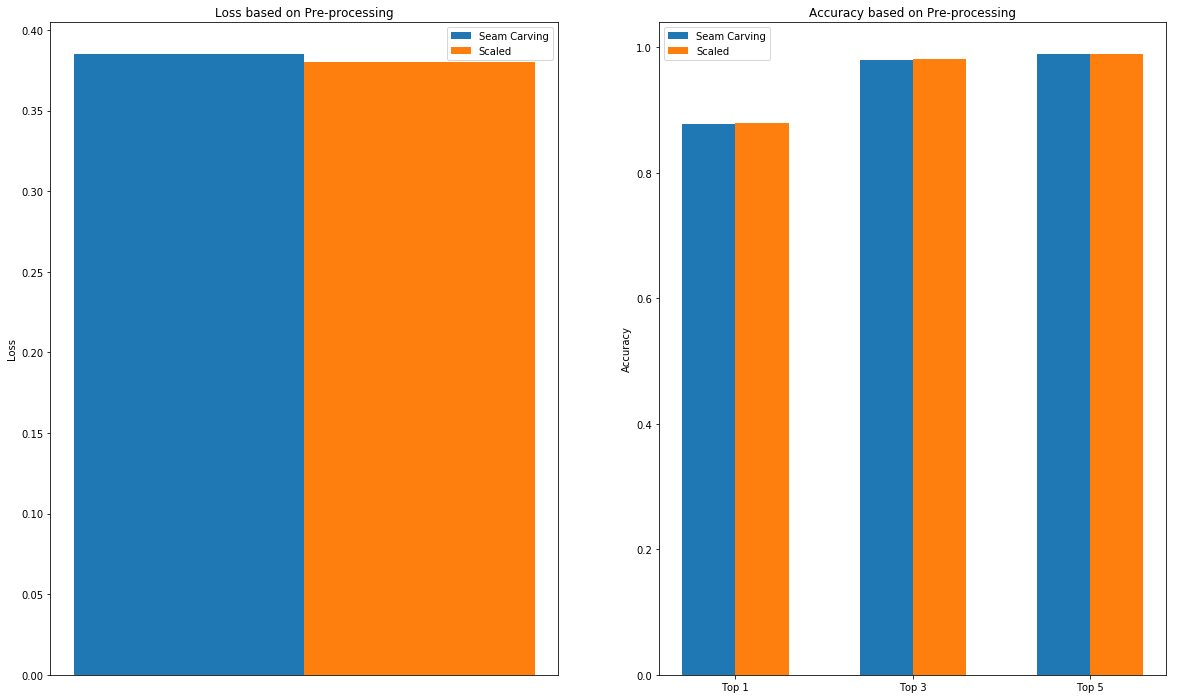

In [119]:
x = np.arange(3)
width = 0.3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

rects1 = ax1.bar(0 - width/2, score_seamed[0], width, label='Seam Carving')
rects2 = ax1.bar(0 + width/2, score_scaled[0], width, label='Scaled')

rects1 = ax2.bar(x - width/2, score_seamed[1:], width, label='Seam Carving')
rects2 = ax2.bar(x + width/2, score_scaled[1:], width, label='Scaled')

ax1.set_ylabel('Loss')
ax1.set_title('Loss based on Pre-processing')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.legend()

ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy based on Pre-processing')
ax2.set_xticks(x)
ax2.set_xticklabels(["Top 1", "Top 3", "Top 5"])
ax2.legend()

plt.show()

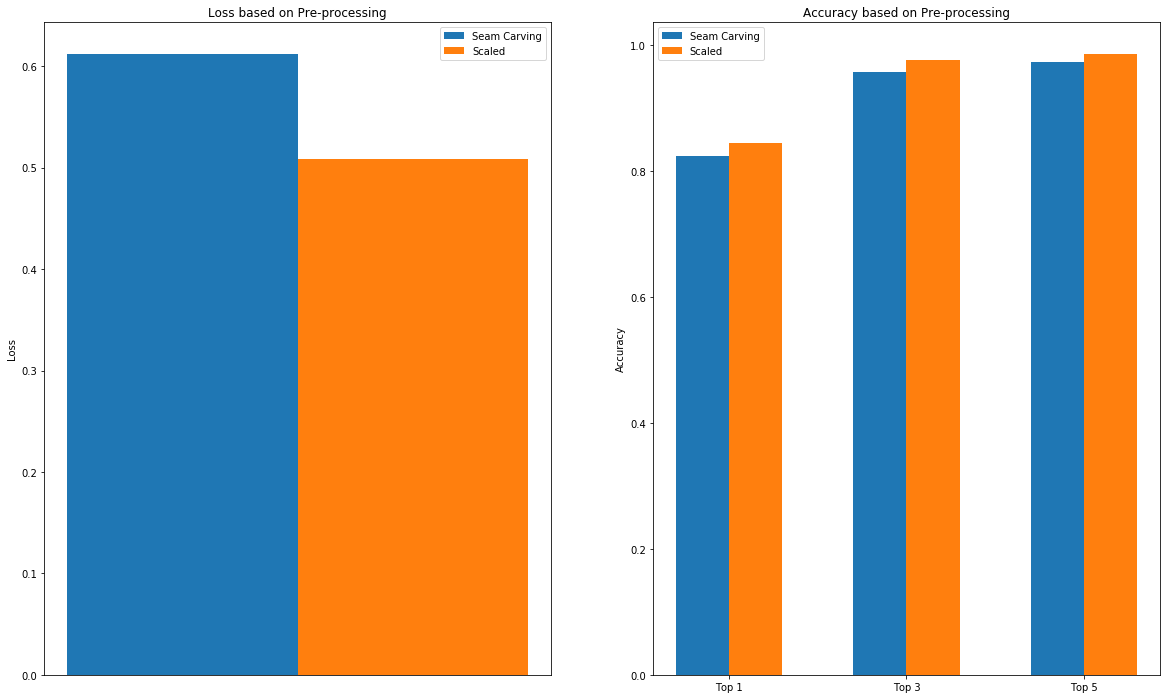

In [120]:
x = np.arange(3)
width = 0.3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

rects1 = ax1.bar(0 - width/2, score_seamed_eval[0], width, label='Seam Carving')
rects2 = ax1.bar(0 + width/2, score_scaled_eval[0], width, label='Scaled')

rects1 = ax2.bar(x - width/2, score_seamed_eval[1:], width, label='Seam Carving')
rects2 = ax2.bar(x + width/2, score_scaled_eval[1:], width, label='Scaled')

ax1.set_ylabel('Loss')
ax1.set_title('Loss based on Pre-processing')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.legend()

ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy based on Pre-processing')
ax2.set_xticks(x)
ax2.set_xticklabels(["Top 1", "Top 3", "Top 5"])
ax2.legend()

plt.show()

Strangely, it seems that seam carving makes result worse... This could be explained due to the destruction for some features as we remove complete columns. However, I was not expecting this result based on the previous notebook...

# Conclusion

In this Notebook, I wanted to use the method of Seam Carving on a complete dataset to check if this could gives benefit for non squared images. However, it seems that the benefit saw previously doesn't work on a larger scale. The loss and the accuracy decreased due to those images. 

An alternate test would be to use the Seam Carving on images with a ration > 1.51 to reduce them only to a ratio of 1.50 for example and then apply a scaling (currenly, I use Seam carving up to a ratio of 1). Maybe less features would be destroyed and a benefit would be here. Due to the time to compute this, I'll not test it on this Notebook but probably in a near future.